In [13]:
import numpy as np
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
coll = client["News"]["features2_w2v"]

X_list, y_list = [], []
for d in coll.find({}, {"_id":0}).sort("idx", 1):
    X_list.extend(d["X"])
    y_list.extend(d["y"])
X_rec = np.array(X_list, dtype=np.float32)
y_rec = np.array(y_list)
print(X_rec.shape, y_rec.shape)

(44182, 100) (44182,)


In [14]:
X_rec

array([[-0.14576551,  0.20846634,  0.19916436, ...,  0.07032482,
         0.04025758, -0.32057312],
       [-0.07765286,  0.15813601,  0.34665048, ...,  0.03394436,
        -0.00245274, -0.36184576],
       [ 0.00100248,  0.08843064,  0.20083056, ...,  0.12334862,
         0.02798297, -0.3715067 ],
       ...,
       [-0.19437018,  0.26075804,  0.26103425, ...,  0.01103982,
         0.07664921, -0.3617203 ],
       [-0.30282566,  0.25800672,  0.32357222, ..., -0.09570906,
         0.13183808, -0.418988  ],
       [-0.33571106,  0.31191632,  0.28925517, ...,  0.01730149,
         0.11054684, -0.4036947 ]], dtype=float32)

In [15]:
y_rec

array(['1', '1', '1', ..., '0', '0', '0'], dtype='<U1')

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Riproducibilità
np.random.seed(42)
tf.random.set_seed(42)

print("Shape X:", X_rec.shape, "dtype:", X_rec.dtype)
print("Shape y:", y_rec.shape, "dtype:", y_rec.dtype)


Shape X: (44182, 100) dtype: float32
Shape y: (44182,) dtype: <U1


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Etichette: da stringhe a int
y = (y_rec.astype(str) == '1').astype(int)   # 1=fake, 0=vera
X = X_rec.astype(np.float32)

# Split stratificato: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Class weights (per gestire squilibrio)
classes = np.unique(y_train)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("class_weight:", class_weight)


Train: (30927, 100) Val: (6627, 100) Test: (6628, 100)
class_weight: {0: 1.0315189113468082, 1: 0.9703501506024096}


In [18]:
def build_mlp(input_dim, hidden=(256, 128), dropout=0.30, l2=1e-4, lr=1e-3):
    inputs = keras.Input(shape=(input_dim,), name="dense_features")
    x = layers.BatchNormalization()(inputs)

    x = layers.Dense(hidden[0], activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(hidden[1], activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc")
        ]
    )
    return model

model = build_mlp(input_dim=X.shape[1])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_features (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,281 (231.57 KB)

 Trainable params: 59,081 (230.79 KB)

 Non-trainable params: 200 (800.00 B)

In [19]:
early = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
reduce = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=256,
    callbacks=[early, reduce],
    class_weight=class_weight,   # rimuovi se bilanciate
    verbose=1
)


Epoch 1/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8805 - auc: 0.9443 - loss: 0.3043 - precision: 0.8868 - recall: 0.8882 - val_accuracy: 0.9439 - val_auc: 0.9917 - val_loss: 0.3947 - val_precision: 0.9792 - val_recall: 0.9104 - learning_rate: 0.0010
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9569 - auc: 0.9919 - loss: 0.1413 - precision: 0.9618 - recall: 0.9546 - val_accuracy: 0.9650 - val_auc: 0.9943 - val_loss: 0.2555 - val_precision: 0.9772 - val_recall: 0.9543 - learning_rate: 0.0010
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9653 - auc: 0.9944 - loss: 0.1194 - precision: 0.9690 - recall: 0.9638 - val_accuracy: 0.9680 - val_auc: 0.9952 - val_loss: 0.1642 - val_precision: 0.9726 - val_recall: 0.9652 - learning_rate: 0.0010
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9674 - auc: 0.9949 - loss: 0.1138 - precision: 0.9715 - recall: 0.9653 - val_accuracy: 0.9710 - val_auc: 0.9957 - val_loss: 0.1181 -

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# Predizioni probabilistiche
probs = model.predict(X_test).ravel()

# Default threshold 0.5
preds = (probs >= 0.5).astype(int)
print("== Confusion matrix @0.5 ==")
print(confusion_matrix(y_test, preds))
print("\n== Classification report ==")
print(classification_report(y_test, preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, probs))

# Soglia che massimizza F1 (su validation set)
val_probs = model.predict(X_val).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2*prec*rec/(prec+rec+1e-8)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (val):", best_thr)

pred_best = (probs >= best_thr).astype(int)
print("\n== Report con soglia ottimizzata ==")
print(classification_report(y_test, pred_best, digits=3))


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
== Confusion matrix @0.5 ==
[[3132   81]
 [  81 3334]]

== Classification report ==
              precision    recall  f1-score   support

           0      0.975     0.975     0.975      3213
           1      0.976     0.976     0.976      3415

    accuracy                          0.976      6628
   macro avg      0.976     0.976     0.976      6628
weighted avg      0.976     0.976     0.976      6628

ROC-AUC: 0.9967286084760894
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Best threshold (val): 0.4925838

== Report con soglia ottimizzata ==
              precision    recall  f1-score   support

           0      0.975     0.974     0.974      3213
           1      0.975     0.976     0.976      3415

    accuracy                          0.975      6628
   macro avg      0.975     0.975     0.975      6628
weighted avg      0.975     0.975     0.975      6628



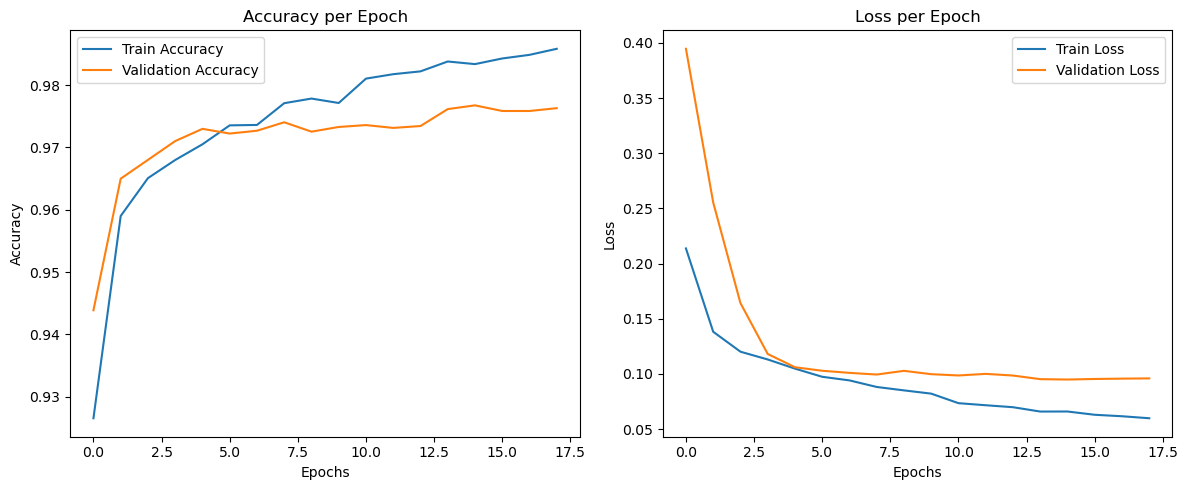

In [21]:
# =========================================
# Andamento Accuracy e Loss per epoca
# =========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.tight_layout()
plt.show()


1. Accuracy

All’inizio l’accuratezza di training parte intorno al 93%, mentre quella di validation è leggermente più alta (≈94.5%). Questo succede spesso quando il modello ha dropout/regolarizzazione attivi: in training è penalizzato, mentre la validation (dove il dropout è spento) appare inizialmente migliore.

Dopo poche epoche entrambe le curve crescono in parallelo: il training raggiunge quasi il 99%, mentre la validation si stabilizza intorno al 97.5%–97.7%.

La distanza tra train e validation rimane limitata (≈1.5%): indice che il modello sta generalizzando bene, con un overfitting contenuto.

2. Loss

La loss di training cala in modo regolare da ≈0.21 a meno di 0.06: significa che il modello riduce progressivamente l’errore sui dati che vede durante l’addestramento.

La loss di validation scende rapidamente da ≈0.40 a ≈0.10 già entro le prime 3–5 epoche e poi si stabilizza, senza crescere in modo significativo.

Questo è un buon segnale: non osserviamo divergenze forti (che sarebbero tipiche di un overfitting serio).

3. Interpretazione didattica

Prime epoche → forte apprendimento dei pattern di base, con miglioramento rapido sia in training che in validation.

Epoche successive → il modello continua a migliorare sul training, ma sulla validation si osserva un plateau: sta imparando dettagli specifici del training set che non si traducono in veri guadagni di generalizzazione.

Il gap moderato train/val è fisiologico e accettabile, soprattutto in un problema con embedding ricchi come questo.

4. Messaggio agli studenti

Questi grafici ci insegnano tre cose fondamentali:

Il modello impara davvero: vediamo una crescita stabile dell’accuracy e una riduzione della loss, non è solo rumore.

Il validation set è cruciale: ci mostra quando il modello smette di migliorare realmente; in questo caso dopo circa 6–8 epoche.

Early Stopping: una tecnica come l’early stopping avrebbe potuto fermare l’allenamento in quel punto, evitando epoche extra senza reale beneficio.

“L’andamento di accuracy e loss mostra un apprendimento stabile: l’accuratezza di training cresce fino al 99% mentre quella di validazione si stabilizza intorno al 97.5%, con un divario limitato che segnala un overfitting contenuto. La loss di validazione raggiunge rapidamente un plateau dopo poche epoche, indicando che un early stopping avrebbe potuto arrestare l’allenamento senza perdita di performance.”

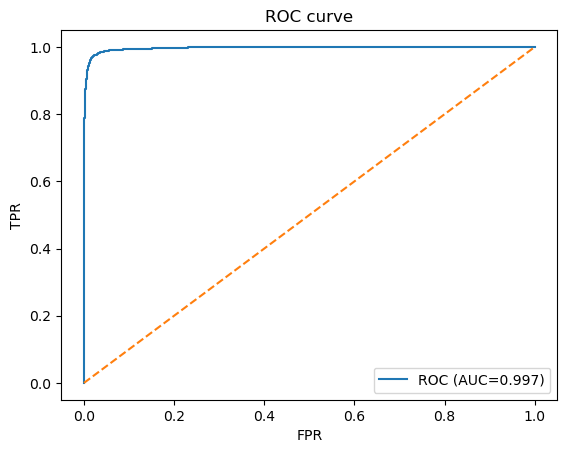

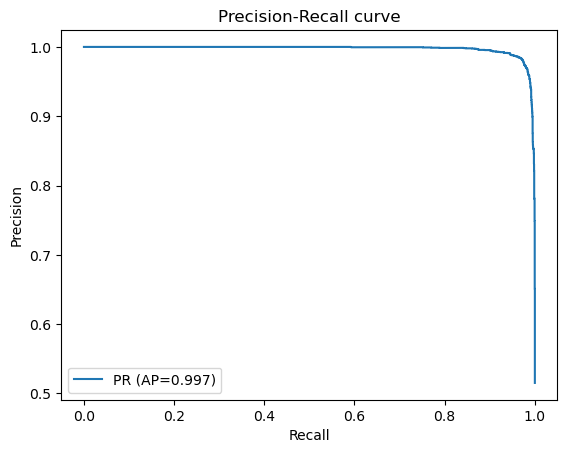

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, average_precision_score

# ROC
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(y_test, probs):.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend()
plt.show()

# PR
ap = average_precision_score(y_test, probs)
pr_prec, pr_rec, _ = precision_recall_curve(y_test, probs)
plt.plot(pr_rec, pr_prec, label=f"PR (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend()
plt.show()


1. Curva ROC (Receiver Operating Characteristic)

La curva blu rappresenta la capacità del modello di distinguere tra le classi (fake vs real) al variare della soglia di decisione.

L’asse X è il False Positive Rate (FPR) e l’asse Y è il True Positive Rate (TPR).

La curva sale immediatamente verso l’alto e rimane aderente al bordo sinistro e superiore del grafico: questo indica che il modello riesce ad avere TPR molto alto con FPR molto basso.

L’AUC è 0.997, praticamente perfetto: significa che il modello distingue correttamente una notizia vera da una fake il 99.7% delle volte indipendentemente dalla soglia scelta.

2. Curva Precision–Recall

La Precision-Recall è particolarmente utile quando le classi sono sbilanciate, perché ci mostra come il modello bilancia la capacità di riconoscere correttamente i fake (recall) senza introdurre troppi falsi positivi (precision).

Vediamo che la curva rimane vicina al valore massimo (precision ≈ 1, recall ≈ 1) per quasi tutto l’intervallo. Solo quando il recall si avvicina al 100% la precision cala leggermente, come è normale.

L’Average Precision (AP) è 0.997, segno che il modello riesce quasi sempre a mantenere sia alta precision che recall contemporaneamente.

3. Interpretazione didattica

I due grafici insieme ci mostrano che il modello è estremamente efficace: sia in termini di separazione globale delle classi (ROC), sia in termini di compromesso precision–recall (PR).

Risultati così alti possono significare due cose:

Il modello è davvero molto buono perché le embedding contengono informazioni altamente discriminanti.

Oppure il dataset è relativamente “facile” da separare o esiste un rischio di data leakage (informazioni nel train che aiutano troppo sul test).

Come data scientist, davanti a risultati quasi perfetti bisogna sempre essere prudenti e verificare la qualità e l’indipendenza dei dati di validazione/test.

4. Messaggio agli studenti

La ROC curve ci dice: “il modello distingue benissimo le due classi in senso generale”.

La Precision-Recall curve aggiunge: “e non lo fa barando: mantiene allo stesso tempo recall e precision quasi perfetti”.

Insieme, questi grafici ci mostrano un modello altamente performante e ci ricordano l’importanza di usare metriche complementari per avere un quadro completo delle performance.

Le curve ROC e Precision–Recall confermano l’elevata capacità discriminante del modello, con valori di AUC e AP pari a 0.997. La ROC mostra che il classificatore mantiene un alto tasso di veri positivi con pochi falsi positivi, mentre la PR evidenzia che precision e recall restano quasi perfetti lungo tutto l’intervallo. Questi risultati indicano un modello estremamente efficace, sebbene sia necessaria cautela per escludere fenomeni di data leakage o overfitting.”

In [25]:
print(classification_report(y_test, pred_best, digits=3))

              precision    recall  f1-score   support

           0      0.975     0.974     0.974      3213
           1      0.975     0.976     0.976      3415

    accuracy                          0.975      6628
   macro avg      0.975     0.975     0.975      6628
weighted avg      0.975     0.975     0.975      6628



In [27]:
from sklearn.metrics import classification_report
import pandas as pd

# Supponiamo di avere y_true e y_pred (reti neurali, soglia 0.5 o best_thr)
report = classification_report(y_test, pred_best, digits=3, output_dict=True)

# Nel report troviamo già 'accuracy' come singolo valore,
# e precision/recall/f1 sotto le chiavi 'weighted avg' o 'macro avg'
acc  = report['accuracy']
prec = report['macro avg']['precision']
rec  = report['macro avg']['recall']
f1   = report['macro avg']['f1-score']

# Costruiamo il dizionario per la NN
nn_metrics = {
    "model": "NeuralNetwork",
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1
}

nn_df = pd.DataFrame([nn_metrics])



In [28]:
nn_df

,model,accuracy,precision,recall,f1
0,NeuralNetwork,0.975106,0.975095,0.975069,0.975082


In [29]:
dataNONN = {
    "model": ["LogReg", "LinearSVM", "RandomForest", "GaussianNB", "DecisionTree", "KNN"],
    "accuracy": [0.957112, 0.957791, 0.961412, 0.900192, 0.916487, 0.938101],
    "precision": [0.956984, 0.957691, 0.961391, 0.900058, 0.917366, 0.938387],
    "recall": [0.957277, 0.957845, 0.961359, 0.900189, 0.915839, 0.938720],
    "f1": [0.957087, 0.957759, 0.961375, 0.900116, 0.916285, 0.938097],
}

dfNONN = pd.DataFrame(dataNONN)

In [36]:
results_df = pd.concat([dfNONN, nn_df], ignore_index=True)
results_df.style.format({
    "accuracy": "{:.4f}",
    "precision": "{:.4f}",
    "recall": "{:.4f}",
    "f1": "{:.4f}"
})

results_df


,model,accuracy,precision,recall,f1
0,LogReg,0.957,0.957,0.957,0.957
1,LinearSVM,0.958,0.958,0.958,0.958
2,RandomForest,0.961,0.961,0.961,0.961
3,GaussianNB,0.900,0.900,0.900,0.900
4,DecisionTree,0.916,0.917,0.916,0.916
5,KNN,0.938,0.938,0.939,0.938
6,NeuralNetwork,0.975,0.975,0.975,0.975


In [37]:
results_df_rounded = results_df.round(4)


In [38]:
results_df_rounded

,model,accuracy,precision,recall,f1
0,LogReg,0.957,0.957,0.957,0.957
1,LinearSVM,0.958,0.958,0.958,0.958
2,RandomForest,0.961,0.961,0.961,0.961
3,GaussianNB,0.900,0.900,0.900,0.900
4,DecisionTree,0.916,0.917,0.916,0.916
5,KNN,0.938,0.938,0.939,0.938
6,NeuralNetwork,0.975,0.975,0.975,0.975


In [40]:
results_df_rounded.to_csv(r"C:\Users\DAVIDEPEDRETTI\Desktop\NLP_news\Word2Vect_Metrics.csv")